In [31]:
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from tifffile import imread
from csbdeep.io import save_tiff_imagej_compatible
import glob
from aicspylibczi import CziFile
import os
import tifffile

In [2]:
model_name = 'n2v_3D_6channel'
basedir = 'N2V_models'
model = N2V(config=None, name=model_name, basedir=basedir)

2022-09-04 14:26:55.700382: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-04 14:26:55.701463: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-04 14:26:55.787229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-04 14:26:55.788742: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.56GiB deviceMemoryBandwidth: 298.08GiB/s
2022-09-04 14:26:55.788787: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-04 14:26:55.790997: I tensorflow/stream_executor/platform/default/dso_loade

Loading network weights from 'weights_best.h5'.


In [3]:
path = glob.glob('/mnt/shared/potatoshapes/shannonsdata/raw_data/3D_data/*.czi')


In [4]:
len(path)

124

In [ ]:
# img, shape = CziFile(path[1]).read_image() # image of index 1 has a problem (maybe not uploaded yet or maybe corrupt from bad upload)
# # print(img.shape)
# img = np.squeeze(img)
# # print(img.shape)
# if img.shape[0] == 7:
#     img = img[:-1,...]
# # print(img.shape)
# img = np.moveaxis(img, [0], [3])
# # print(img.shape)
# img_SZYXC = np.expand_dims(img, axis=0)
# print(img_SZYXC.shape)

In [34]:
img_SZYXC_list = []
file_names = []
for i,this_path in enumerate(path[:5]):
    file_names.append(this_path)
    img, shape = CziFile(this_path).read_image() # image of index 1 has a problem (maybe not uploaded yet or maybe corrupt from bad upload)
    print(img.shape)
    img = np.squeeze(img)
    print(img.shape)
    if img.shape[0] == 7:
        img = img[:-1,...]
    print(img.shape)
    img = np.moveaxis(img, [0], [3])
    print(img.shape)
    img_SZYXC_list.append(np.expand_dims(img, axis=0))
    print(img_SZYXC_list[i].shape)


(1, 1, 1, 7, 15, 1688, 1688)
(7, 15, 1688, 1688)
(6, 15, 1688, 1688)
(15, 1688, 1688, 6)
(1, 15, 1688, 1688, 6)
(1, 1, 1, 6, 33, 1688, 1688)
(6, 33, 1688, 1688)
(6, 33, 1688, 1688)
(33, 1688, 1688, 6)
(1, 33, 1688, 1688, 6)
(1, 1, 1, 7, 22, 1688, 1688)
(7, 22, 1688, 1688)
(6, 22, 1688, 1688)
(22, 1688, 1688, 6)
(1, 22, 1688, 1688, 6)
(1, 1, 1, 7, 19, 1688, 1688)
(7, 19, 1688, 1688)
(6, 19, 1688, 1688)
(19, 1688, 1688, 6)
(1, 19, 1688, 1688, 6)
(1, 1, 1, 6, 34, 1688, 1688)
(6, 34, 1688, 1688)
(6, 34, 1688, 1688)
(34, 1688, 1688, 6)
(1, 34, 1688, 1688, 6)


In [37]:
print(len(img_SZYXC_list))

5


In [ ]:
# img_lys = img_SZYXC[0,:,744:944,744:944,:]
# print(img_lys.shape`)

In [9]:
# pred = model.predict(img_SZYXC_list[0][0,:,744:944,744:944,:], axes='ZYXC')
# pred.shape

The input image is of type uint16 and will be casted to float32 for prediction.


2022-09-04 14:30:49.019454: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-04 14:30:49.039009: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz
2022-09-04 14:30:50.398478: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-09-04 14:30:51.646015: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-09-04 14:30:51.796860: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-09-04 14:30:53.254541: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


(15, 200, 200, 6)

In [84]:
save_dir = '/mnt/shared/potatoshapes/shannonsdata/N2V_predictions/'
pred_list = []
for idx,img in enumerate(img_SZYXC_list):
    pred = model.predict(img[0,:,744:944,744:944,:], axes='ZYXC')
    pred_list.append(pred)
#     print(pred.shape)
    name_construct = os.path.basename(file_names[idx])[:-4].replace(' ', '-')
    name = f'{name_construct}_prediction.tiff'
#     print(name_construct)
    tiff_to_write = np.moveaxis(pred, [0], [2])
    tifffile.imwrite(os.path.join(save_dir, name), data=tiff_to_write)

The input image is of type uint16 and will be casted to float32 for prediction.
The input image is of type uint16 and will be casted to float32 for prediction.
The input image is of type uint16 and will be casted to float32 for prediction.
The input image is of type uint16 and will be casted to float32 for prediction.
The input image is of type uint16 and will be casted to float32 for prediction.


In [52]:
print(len(pred_list))
pred = pred_list[0]

5


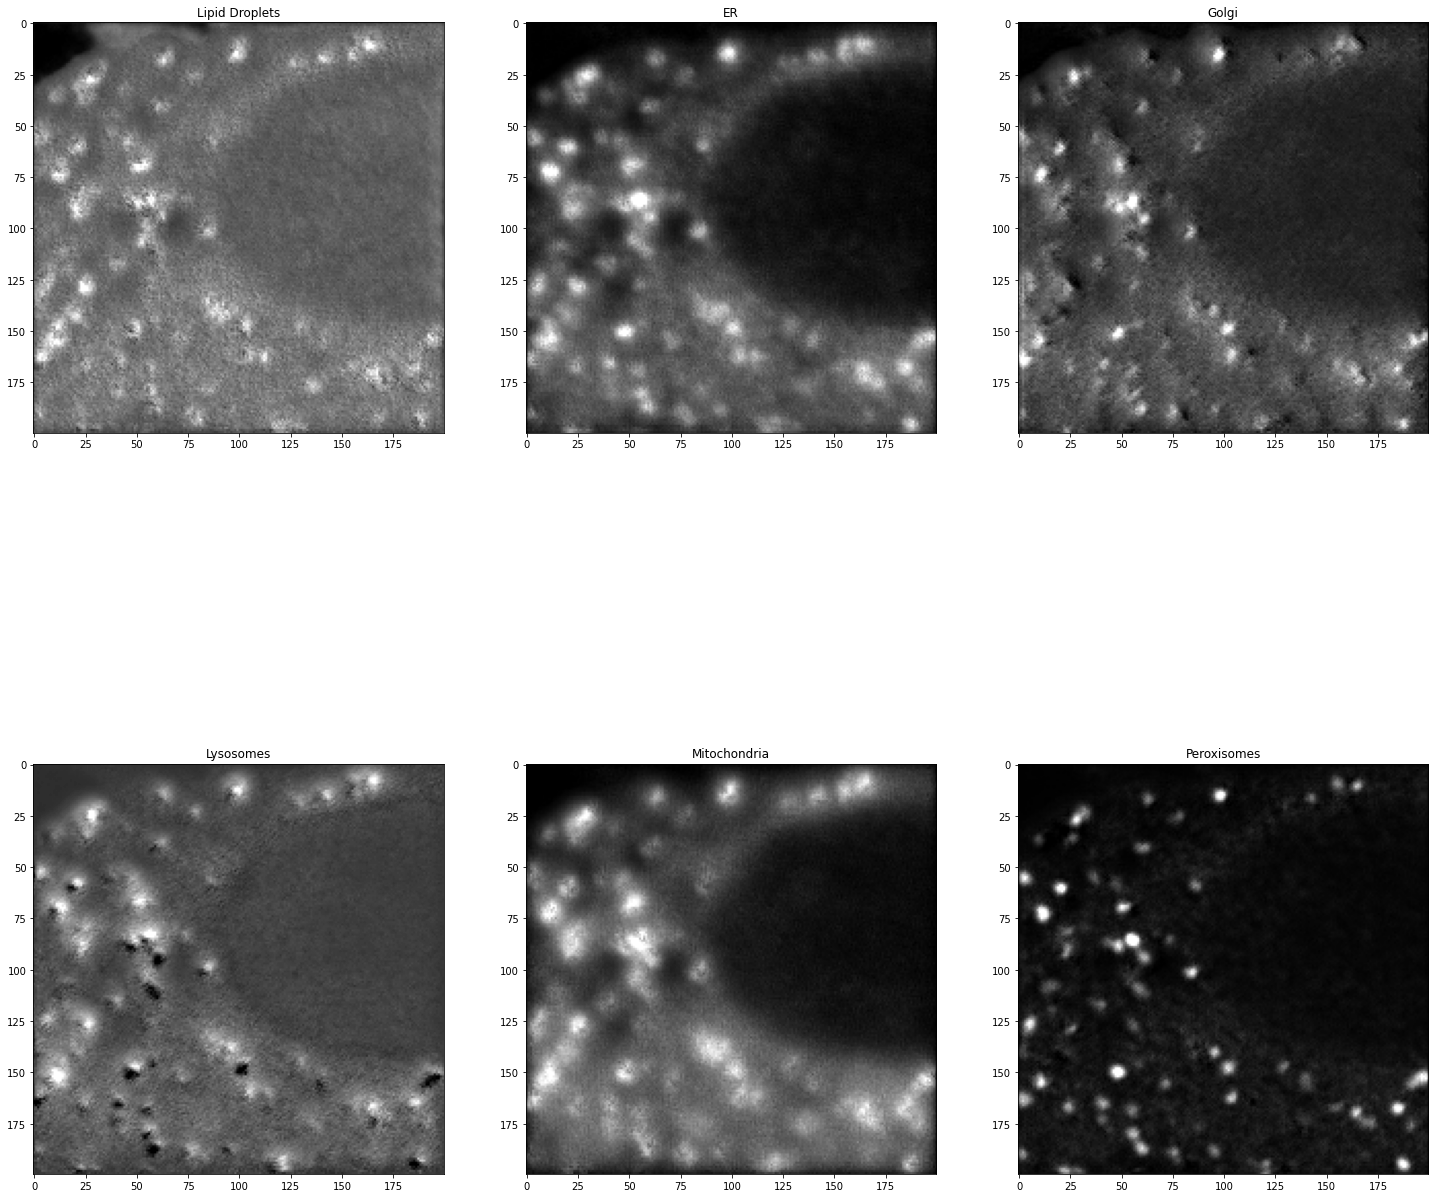

In [57]:
def norm_by(x, min_, max_):
    norms = np.percentile(x, [min_, max_])
    i2 = np.clip((x - norms[0])/(norms[1]-norms[0]), 0, 1)
    return i2

c0 = (norm_by(pred[5, :, :, 0], .2, 99.8)*255).astype(np.uint8)
c1 = (norm_by(pred[5, :, :, 1], .2, 99.8)*255).astype(np.uint8)
c2 = (norm_by(pred[5, :, :, 2], .2, 99.8)*255).astype(np.uint8)
c3 = (norm_by(pred[5, :, :, 3], .2, 99.8)*255).astype(np.uint8)
c4 = (norm_by(pred[5, :, :, 4], .2, 99.8)*255).astype(np.uint8)
c5 = (norm_by(pred[5, :, :, 5], .2, 99.8)*255).astype(np.uint8)
plt.figure(figsize=(25,25))
plt.subplot(2,3,1)
plt.imshow(c0, cmap='gray')
plt.title('Lipid Droplets');
plt.subplot(2,3,2)
plt.imshow(c1, cmap='gray')
plt.title('ER');
plt.subplot(2,3,3)
plt.imshow(c2, cmap='gray')
plt.title('Golgi');
plt.subplot(2,3,4)
plt.imshow(c3, cmap='gray')
plt.title('Lysosomes');
plt.subplot(2,3,5)
plt.imshow(c4, cmap='gray')
plt.title('Mitochondria');
plt.subplot(2,3,6)
plt.imshow(c5, cmap='gray')
plt.title('Peroxisomes')
plt.show()

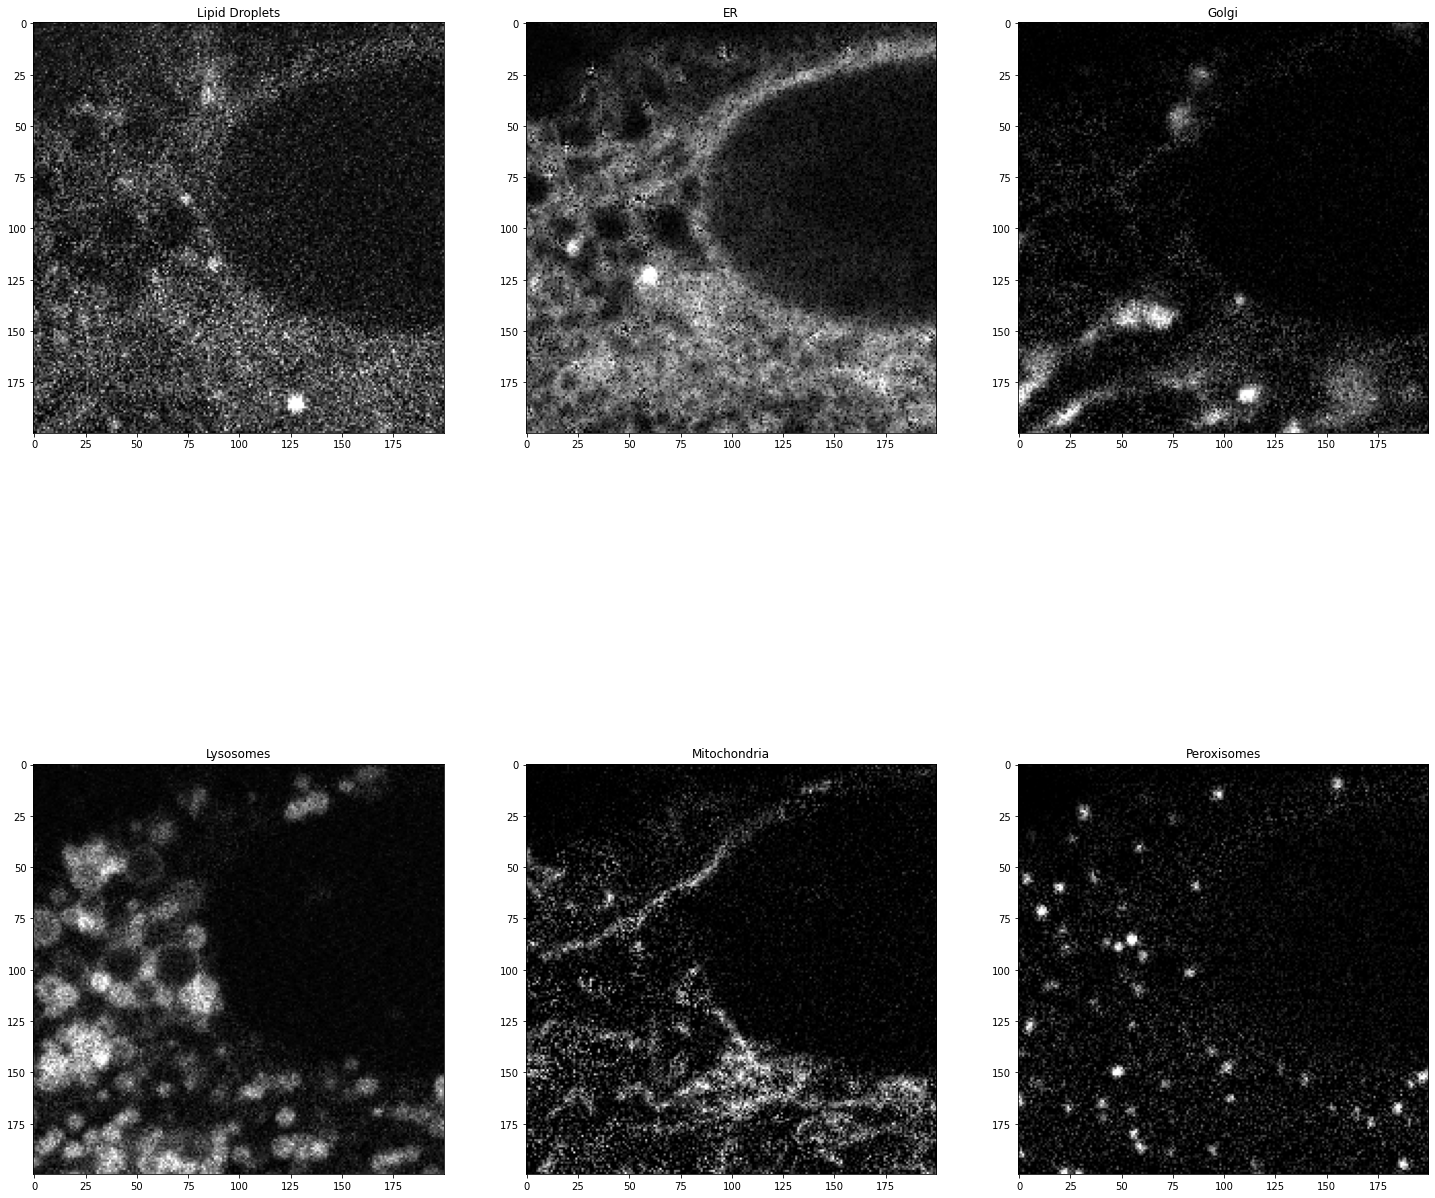

In [58]:
def norm_by(x, min_, max_):
    norms = np.percentile(x, [min_, max_])
    i2 = np.clip((x - norms[0])/(norms[1]-norms[0]), 0, 1)
    return i2

c0 = (norm_by(img_SZYXC_list[0][0,5, 744:944,744:944, 0], .2, 99.8)*255).astype(np.uint8)
c1 = (norm_by(img_SZYXC_list[0][0,5, 744:944,744:944, 1], .2, 99.8)*255).astype(np.uint8)
c2 = (norm_by(img_SZYXC_list[0][0,5, 744:944,744:944, 2], .2, 99.8)*255).astype(np.uint8)
c3 = (norm_by(img_SZYXC_list[0][0,5, 744:944,744:944, 3], .2, 99.8)*255).astype(np.uint8)
c4 = (norm_by(img_SZYXC_list[0][0,5, 744:944,744:944, 4], .2, 99.8)*255).astype(np.uint8)
c5 = (norm_by(img_SZYXC_list[0][0,5, 744:944,744:944, 5], .2, 99.8)*255).astype(np.uint8)
plt.figure(figsize=(25,25))
plt.subplot(2,3,1)
plt.imshow(c0, cmap='gray')
plt.title('Lipid Droplets');
plt.subplot(2,3,2)
plt.imshow(c1, cmap='gray')
plt.title('ER');
plt.subplot(2,3,3)
plt.imshow(c2, cmap='gray')
plt.title('Golgi');
plt.subplot(2,3,4)
plt.imshow(c3, cmap='gray')
plt.title('Lysosomes');
plt.subplot(2,3,5)
plt.imshow(c4, cmap='gray')
plt.title('Mitochondria');
plt.subplot(2,3,6)
plt.imshow(c5, cmap='gray')
plt.title('Peroxisomes')
plt.show()

In [51]:
img_SZYXC_list[3].shape

(1, 19, 1688, 1688, 6)

In [56]:
model.config

N2VConfig(axes='ZYXC', batch_norm=True, means=['336.9215500976562', '344.5290533996582', '118.80120220947266', '213.23487482910156', '75.23125661621094', '85.82042293701171'], n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, n2v_patch_shape=[8, 48, 48], n2v_perc_pix=0.198, n_channel_in=6, n_channel_out=6, n_dim=3, probabilistic=False, single_net_per_channel=True, stds=['282.29935294197037', '1293.2995581735634', '467.6652026200284', '397.62372081447415', '487.4547691365149', '532.827124257516'], structN2Vmask=None, train_batch_size=50, train_checkpoint='weights_best.h5', train_epochs=20, train_learning_rate=0.0004, train_loss='mse', train_reduce_lr={'factor': 0.5, 'patience': 10}, train_steps_per_epoch=5, train_tensorboard=True, unet_input_shape=[None, None, None, 6], unet_kern_size=3, unet_last_activation='linear', unet_n_depth=2, unet_n_first=32, unet_residual=False)

In [60]:
# n = 0
# n_conv_per_depth = 2
# "up_level_%s_no_%s" % (n, n_conv_per_depth)

'up_level_0_no_2'

In [61]:
n = 0
i = 0 #n_conv_per_depth
"down_level_%s_no_%s" % (n, i)

'down_level_0_no_0'